<a href="https://colab.research.google.com/github/AbdalrahmanAbdelaziz/DL-Project/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Extract the dataset
zip_file_path = '/content/drive/My Drive/Colab Notebooks/datasets/archive.zip'  # Update this to your zip file
extract_path = '/content/dataset/'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define paths
dataPath = os.path.join(extract_path, 'car_data/')
Train = os.path.join(dataPath, 'train')
Test = os.path.join(dataPath, 'test')

Mounted at /content/drive


In [ ]:
# Residual Block for ResNet-50
def residual_block(x, filters, kernel_size=3, stride=1, identity=False):
    shortcut = x

    # First convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Apply the shortcut connection
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define ResNet-50 model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define the stages for ResNet-50 architecture
    num_blocks = [3, 4, 6, 3]  # Number of blocks in each stage for ResNet-50
    filters = [64, 128, 256, 512]

    for i in range(4):
        for j in range(num_blocks[i]):
            if i == 0:
                x = residual_block(x, filters[i])
            else:
                x = residual_block(x, filters[i], stride=2 if j == 0 else 1)

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

In [ ]:
# Define input size and number of classes
IMAGE_SIZE = [224, 224, 3]
folders = os.listdir(Train)
num_classes = len(folders)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

training_set = train_datagen.flow_from_directory(
    Train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_set = train_datagen.flow_from_directory(
    Train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_set = test_datagen.flow_from_directory(
    Test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
# Build the ResNet model
model = build_resnet(input_shape=IMAGE_SIZE, num_classes=num_classes)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 112, 112, 64)   │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ activation_9[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 56, 56, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 56, 56, 64)     │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 56, 56, 64)     │              0 │ add_4[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ activation_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 56, 56, 64)     │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (Activation)         

 Total params: 21,410,756 (81.68 MB)

 Trainable params: 21,393,732 (81.61 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [ ]:
# Define callbacks
best_model_file = '/content/drive/My Drive/Colab Notebooks/models/ResNet50_model.keras'
callbacks = [
    ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
]

In [ ]:
# Train the model
r = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=60,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=callbacks
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.0101 - loss: 5.8032
Epoch 1: val_accuracy improved from -inf to 0.00647, saving model to /content/drive/My Drive/Colab Notebooks/models/ResNet50_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 203s 795ms/step - accuracy: 0.0101 - loss: 5.8020 - val_accuracy: 0.0065 - val_loss: 5.6746 - learning_rate: 0.0010
Epoch 2/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/60


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: ac

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.0118 - loss: 5.2530
Epoch 3: val_accuracy improved from 0.00647 to 0.00970, saving model to /content/drive/My Drive/Colab Notebooks/models/ResNet50_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 141s 661ms/step - accuracy: 0.0118 - loss: 5.2529 - val_accuracy: 0.0097 - val_loss: 5.5690 - learning_rate: 0.0010
Epoch 4/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.0146 - loss: 5.1180
Epoch 5: val_accuracy did not improve from 0.00970
207/207 ━━━━━━━━━━━━━━━━━━━━ 135s 638ms/step - accuracy: 0.0146 - loss: 5.1180 - val_accuracy: 0.0091 - val_loss: 7.1306 - learning_rate: 0.0010
Epoch 6/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/60
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.0273 - loss: 5.0396
Epoch 7: val_accuracy impro

In [ ]:
# Train the model
r = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=2,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=callbacks
)

Epoch 1/2
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8992 - loss: 0.3750
Epoch 1: val_accuracy improved from -inf to 0.35382, saving model to /content/drive/My Drive/Colab Notebooks/models/ResNet50_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 187s 754ms/step - accuracy: 0.8991 - loss: 0.3752 - val_accuracy: 0.3538 - val_loss: 3.2176 - learning_rate: 0.0010
Epoch 2/2
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: ac

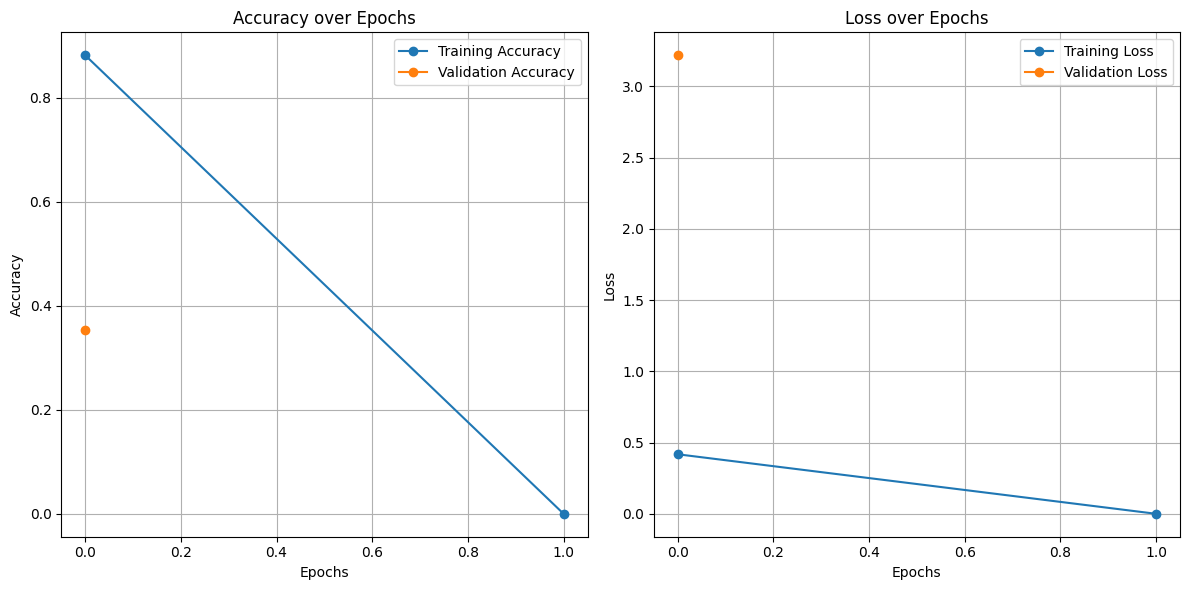

In [ ]:
def plot_training_history(history):
    # Ensure the history object contains expected keys
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.figure(figsize=(12, 6))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("Training history does not contain expected keys. Please check your metrics.")

# Plot training history
plot_training_history(r)

In [ ]:
# Load best model for evaluation
model = load_model('/content/drive/My Drive/Colab Notebooks/models/ResNet50_model.keras')

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.2f}")

252/252 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.3583 - loss: 3.1414
Test Accuracy: 0.39


In [ ]:
y_true = test_set.classes
y_pred_probs = model.predict(test_set, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step


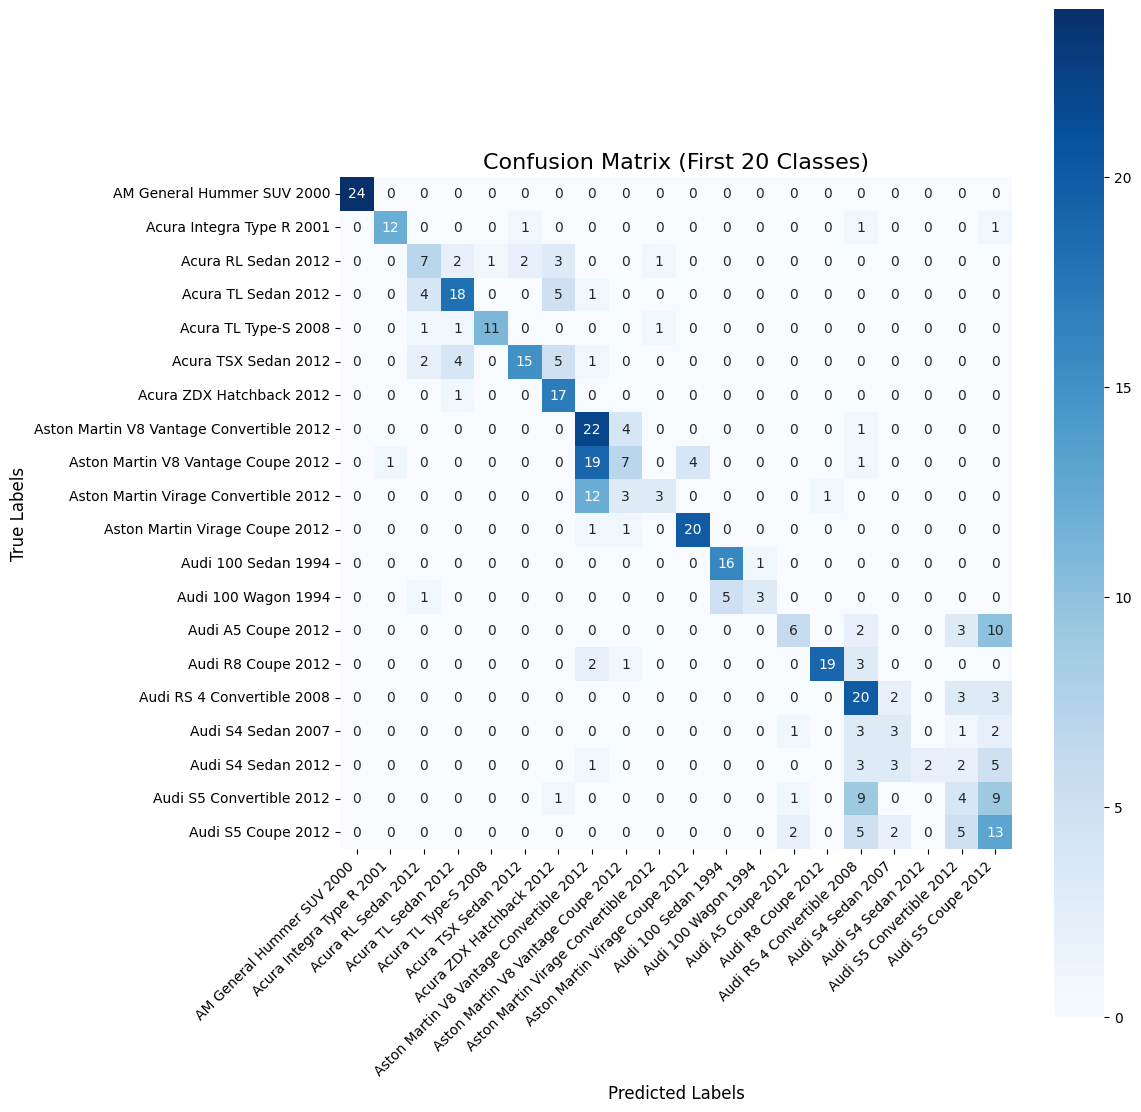

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Get class labels (mapping of class indices to class names)
class_labels = list(test_set.class_indices.keys())

# Plot confusion matrix (only display the first 20 classes if needed)
num_classes_to_display = 20
cm_subset = cm[:num_classes_to_display, :num_classes_to_display]
class_labels_subset = class_labels[:num_classes_to_display]

# Plot the confusion matrix for the first 20 classes
plt.figure(figsize=(12, 12))
sns.heatmap(
    cm_subset,
    annot=True,            # Annotate cells with counts
    fmt='d',               # Display as integers
    cmap='Blues',          # Colormap style
    xticklabels=class_labels_subset,   # X-axis labels
    yticklabels=class_labels_subset,   # Y-axis labels
    cbar=True,             # Include color bar
    square=True            # Square-shaped heatmap
)

# Set titles and labels
plt.title("Confusion Matrix (First 20 Classes)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for better fit
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=list(test_set.class_indices.keys())))


                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.63      0.55      0.59        44
                             Acura Integra Type R 2001       0.34      0.27      0.30        44
                                   Acura RL Sedan 2012       0.37      0.22      0.27        32
                                   Acura TL Sedan 2012       0.62      0.42      0.50        43
                                  Acura TL Type-S 2008       0.69      0.26      0.38        42
                                  Acura TSX Sedan 2012       0.60      0.38      0.46        40
                              Acura ZDX Hatchback 2012       0.33      0.44      0.37        39
              Aston Martin V8 Vantage Convertible 2012       0.13      0.49      0.21        45
                    Aston Martin V8 Vantage Coupe 2012       0.17      0.17      0.17        41
                  Aston Martin Virage C

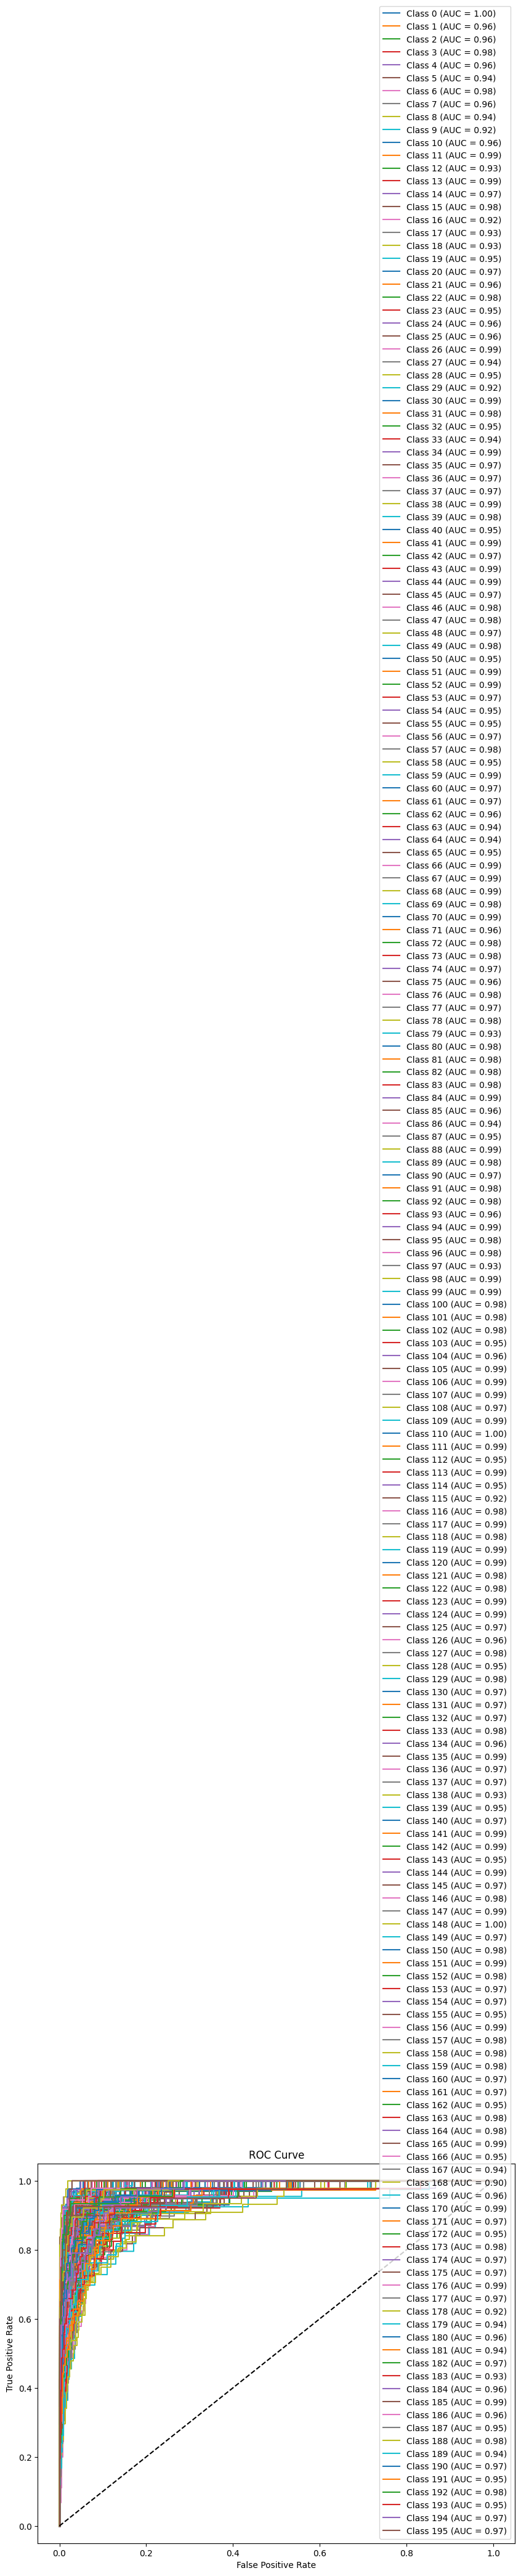

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=len(class_labels))[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def preprocess_image(img_path, img_height=224, img_width=224):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale
    return img_array

In [ ]:
test_image_path = '/content/drive/My Drive/Colab Notebooks/models/download.jpeg'  # Replace with an actual image path

# Preprocess the image
preprocessed_image = preprocess_image(test_image_path)

# Predict the class
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability

# Map the index to the class label
class_labels = list(test_set.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Hyundai Tucson SUV 2012


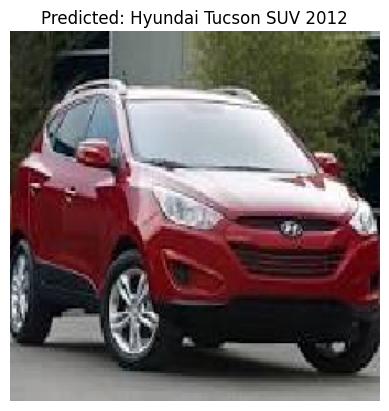

In [ ]:
img = image.load_img(test_image_path, target_size=(224, 224))
preprocessed_image = preprocess_image(test_image_path)

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()